In [13]:
import os
import numpy as np
import torch

# Check if GPU is available and set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"✅ Using device: {device}")

# Set paths for clean and contaminated EEG data
clean_dir = "/home/tulgaa/Desktop/emg_dataset/band/clean"
contaminated_dir = "/home/tulgaa/Desktop/emg_dataset/band/Contaminated"

# Define EEG frequency bands
bands = ["Delta_band", "Theta_band", "Alpha_band", "Beta_band", "Gamma_band", "High_Frequencies_band"]

print(f"✅ Clean EEG Directory: {clean_dir}")
print(f"✅ Contaminated EEG Directory: {contaminated_dir}")
print(f"✅ EEG Bands: {bands}")


✅ Using device: cuda
✅ Clean EEG Directory: /home/tulgaa/Desktop/emg_dataset/band/clean
✅ Contaminated EEG Directory: /home/tulgaa/Desktop/emg_dataset/band/Contaminated
✅ EEG Bands: ['Delta_band', 'Theta_band', 'Alpha_band', 'Beta_band', 'Gamma_band', 'High_Frequencies_band']


In [14]:
import torch.nn as nn
import torch

class ResCNN1D(nn.Module):
    def __init__(self, input_length=512):
        super(ResCNN1D, self).__init__()

        # First Convolutional Layer
        self.conv1 = nn.Conv1d(1, 64, kernel_size=3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm1d(64)

        # Residual Block with Two Convolutions
        self.conv2 = nn.Conv1d(64, 64, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm1d(64)
        self.conv3 = nn.Conv1d(64, 64, kernel_size=5, stride=1, padding=2)
        self.bn3 = nn.BatchNorm1d(64)

        # ✅ FIXED: Residual Connection Now Matches the Input Channels
        self.residual = nn.Conv1d(64, 64, kernel_size=1, stride=1)

        # Final Convolutional Refinement
        self.conv4 = nn.Conv1d(64, 64, kernel_size=3, stride=1, padding=1)
        self.bn4 = nn.BatchNorm1d(64)

        # Fully Connected Layer for Reconstruction
        self.fc = nn.Linear(input_length * 64, input_length)

    def forward(self, x):
        # Ensure input is 3D (batch, channels, sequence)
        if x.dim() == 2:
            x = x.unsqueeze(1)  # Add channel dimension if missing

        # First Conv Layer
        x = torch.relu(self.bn1(self.conv1(x)))

        # ✅ FIXED: Residual Path (Now Uses Correct Input Shape)
        residual = self.residual(x)  # Now it expects 64 channels

        # Residual Block (2 Conv Layers)
        x = torch.relu(self.bn2(self.conv2(x)))
        x = torch.relu(self.bn3(self.conv3(x)))

        # Merge Residual and Main Path
        x = x + residual  # Residual Learning

        # Final Convolutional Refinement
        x = torch.relu(self.bn4(self.conv4(x)))

        # Flatten before fully connected layer
        x = x.view(x.size(0), -1)

        # Fully Connected Layer for Reconstruction
        x = self.fc(x)

        return x

# Print confirmation
print("✅ Fixed ResCNN1D Model Defined Successfully!")


✅ Fixed ResCNN1D Model Defined Successfully!


In [15]:
import torch.optim as optim

# Define Early Stopping Class
class EarlyStopping:
    def __init__(self, patience=10, min_delta=1e-4):
        self.patience = patience
        self.min_delta = min_delta
        self.best_loss = None
        self.counter = 0
        self.stop_training = False

    def __call__(self, current_loss):
        if self.best_loss is None or current_loss < self.best_loss - self.min_delta:
            self.best_loss = current_loss
            self.counter = 0
        else:
            self.counter += 1
            if self.counter >= self.patience:
                self.stop_training = True

# Define Loss Function (MSE)
criterion = nn.MSELoss()

# Define Optimizer (Adam)
input_length = 512  # EEG signal length
model = ResCNN1D().to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Early stopping instance
early_stopping = EarlyStopping(patience=10, min_delta=1e-4)

# Print confirmation
print("✅ Loss function, optimizer, and early stopping defined successfully!")


✅ Loss function, optimizer, and early stopping defined successfully!


In [17]:
from sklearn.model_selection import train_test_split

def load_and_split_data(band_name):
    """
    Loads EEG data for a specific frequency band, splits into train and test sets based on SNR levels.
    """
    print(f"\n📌 Loading and Splitting Data for {band_name}...")

    # Load clean EEG data
    clean_band_path = os.path.join(clean_dir, f"{band_name}.npy")
    clean_band = np.load(clean_band_path)

    # Load contaminated EEG data across all SNR levels
    contaminated_band = []
    snr_labels = []

    for snr_folder in sorted(os.listdir(contaminated_dir)):  # Iterate through SNR folders
        contaminated_band_path = os.path.join(contaminated_dir, snr_folder, f"{band_name}.npy")
        contaminated_data = np.load(contaminated_band_path)

        contaminated_band.append(contaminated_data)
        snr_labels.extend([snr_folder] * len(contaminated_data))  # Track SNR levels

    # Convert lists to numpy arrays
    contaminated_band = np.concatenate(contaminated_band, axis=0)
    # Convert string labels ("SNR_-7") to integers (-7)
    
    snr_labels = np.array([int(snr.replace("SNR_", "")) for snr in snr_labels])


    # Ensure clean_band is correctly repeated to match contaminated EEG samples
    clean_band_repeated = np.tile(clean_band, (len(contaminated_band) // len(clean_band) + 1, 1))[:len(contaminated_band)]

    # Stratified Train-Test Split
    train_clean, test_clean, train_contaminated, test_contaminated, snr_labels_train, snr_labels_test = train_test_split(
        clean_band_repeated, contaminated_band, snr_labels, test_size=0.2, stratify=snr_labels, random_state=42
    )

    # Inspect data shapes
    print(f"✅ {band_name} Train Clean Shape: {train_clean.shape}, Test Clean Shape: {test_clean.shape}")
    print(f"✅ {band_name} Train Contaminated Shape: {train_contaminated.shape}, Test Contaminated Shape: {test_contaminated.shape}")
    print(f"✅ {band_name} SNR Labels Train: {np.unique(snr_labels_train)}, Test: {np.unique(snr_labels_test)}")

    return train_clean, train_contaminated, test_clean, test_contaminated, snr_labels_train, snr_labels_test

# Load and split data for each EEG band
train_data = {}
test_data = {}

for band in bands:
    train_clean, train_contaminated, test_clean, test_contaminated, snr_labels_train, snr_labels_test = load_and_split_data(band)
    train_data[band] = (train_clean, train_contaminated)
    test_data[band] = (test_clean, test_contaminated, snr_labels_test)

print("\n✅ All EEG bands successfully loaded and split!")



📌 Loading and Splitting Data for Delta_band...
✅ Delta_band Train Clean Shape: (36112, 1024), Test Clean Shape: (9028, 1024)
✅ Delta_band Train Contaminated Shape: (36112, 1024), Test Contaminated Shape: (9028, 1024)
✅ Delta_band SNR Labels Train: [-7 -6 -5 -4 -3 -2 -1  0  1  2], Test: [-7 -6 -5 -4 -3 -2 -1  0  1  2]

📌 Loading and Splitting Data for Theta_band...
✅ Theta_band Train Clean Shape: (36112, 1024), Test Clean Shape: (9028, 1024)
✅ Theta_band Train Contaminated Shape: (36112, 1024), Test Contaminated Shape: (9028, 1024)
✅ Theta_band SNR Labels Train: [-7 -6 -5 -4 -3 -2 -1  0  1  2], Test: [-7 -6 -5 -4 -3 -2 -1  0  1  2]

📌 Loading and Splitting Data for Alpha_band...
✅ Alpha_band Train Clean Shape: (36112, 1024), Test Clean Shape: (9028, 1024)
✅ Alpha_band Train Contaminated Shape: (36112, 1024), Test Contaminated Shape: (9028, 1024)
✅ Alpha_band SNR Labels Train: [-7 -6 -5 -4 -3 -2 -1  0  1  2], Test: [-7 -6 -5 -4 -3 -2 -1  0  1  2]

📌 Loading and Splitting Data for Beta_b

In [18]:
from torch.utils.data import DataLoader, TensorDataset

def train_cnn(train_clean, train_contaminated, test_clean, test_contaminated, band_name):
    """
    Trains the CNN model for EEG denoising on a specific frequency band.
    """
    print(f"\n🚀 Training CNN for {band_name}...")

    # Convert NumPy arrays to PyTorch tensors and move to GPU
    train_clean = torch.tensor(train_clean, dtype=torch.float32).unsqueeze(1).to(device)
    test_clean = torch.tensor(test_clean, dtype=torch.float32).unsqueeze(1).to(device)
    train_contaminated = torch.tensor(train_contaminated, dtype=torch.float32).unsqueeze(1).to(device)
    test_contaminated = torch.tensor(test_contaminated, dtype=torch.float32).unsqueeze(1).to(device)

    # Create DataLoader for training and testing
    train_dataset = TensorDataset(train_contaminated, train_clean)
    test_dataset = TensorDataset(test_contaminated, test_clean)
    train_loader = DataLoader(train_dataset, batch_size=256, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=256, shuffle=False)

    # Define model, optimizer, and loss function
    input_length = train_contaminated.shape[2]  # EEG signal length
    model = ResCNN1D(input_length=input_length).to(device)
    optimizer = optim.Adam(model.parameters(), lr=0.0001)
    criterion = nn.MSELoss()

    early_stopping = EarlyStopping(patience=10, min_delta=1e-4)

    # Train model
    num_epochs = 1000
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0

        for inputs, targets in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets.squeeze(1))
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        avg_train_loss = running_loss / len(train_loader)

        # Evaluate model
        model.eval()
        test_loss = 0.0
        with torch.no_grad():
            for inputs, targets in test_loader:
                outputs = model(inputs)
                loss = criterion(outputs, targets.squeeze(1))
                test_loss += loss.item()

        avg_test_loss = test_loss / len(test_loader)

        print(f"Epoch {epoch + 1}: Train Loss = {avg_train_loss:.4f}, Test Loss = {avg_test_loss:.4f}")

        # Early stopping condition
        early_stopping(avg_test_loss)
        if early_stopping.stop_training:
            print(f"✅ Early stopping triggered for {band_name} at epoch {epoch + 1}")
            break

    # Generate denoised test set predictions

    # Generate denoised test set predictions
    with torch.no_grad():
        denoised_band = model(test_contaminated).squeeze(1).cpu().numpy()

# ✅ Squeeze the 1-channel dimension before returning
    return denoised_band, test_clean.squeeze(1).cpu().numpy()


In [19]:
denoised_bands = []
clean_bands = []

for band in bands:
    train_clean, train_contaminated = train_data[band]
    test_clean, test_contaminated, _ = test_data[band]

    denoised_band, clean_band_test = train_cnn(train_clean, train_contaminated, test_clean, test_contaminated, band)
    
    denoised_bands.append(denoised_band)

    clean_bands.append(clean_band_test)

print("\n✅ All EEG bands successfully trained!")



🚀 Training CNN for Delta_band...
Epoch 1: Train Loss = 9230.4643, Test Loss = 6665.5779
Epoch 2: Train Loss = 6034.2417, Test Loss = 5627.1629
Epoch 3: Train Loss = 5597.1299, Test Loss = 5511.0237
Epoch 4: Train Loss = 5482.2028, Test Loss = 5404.2095
Epoch 5: Train Loss = 5420.0865, Test Loss = 5367.9527
Epoch 6: Train Loss = 5355.6174, Test Loss = 5298.9395
Epoch 7: Train Loss = 5301.4522, Test Loss = 5258.9905
Epoch 8: Train Loss = 5256.5722, Test Loss = 5275.3196
Epoch 9: Train Loss = 5191.5448, Test Loss = 5155.9201
Epoch 10: Train Loss = 5136.2910, Test Loss = 5117.0933
Epoch 11: Train Loss = 5097.2368, Test Loss = 5148.0849
Epoch 12: Train Loss = 5071.0952, Test Loss = 5036.6265
Epoch 13: Train Loss = 5016.7230, Test Loss = 5020.7096
Epoch 14: Train Loss = 4982.6182, Test Loss = 4995.6758
Epoch 15: Train Loss = 4946.1418, Test Loss = 4961.8900
Epoch 16: Train Loss = 4906.5865, Test Loss = 4917.3762
Epoch 17: Train Loss = 4869.3456, Test Loss = 4890.1858
Epoch 18: Train Loss = 

In [24]:
# Reconstruct full EEG signals from denoised frequency bands
denoised_eeg = np.sum(denoised_bands, axis=0)  # Sum across frequency bands
clean_eeg = np.sum(clean_bands, axis=0)

# Ensure both arrays have the same shape
clean_eeg = clean_eeg.squeeze(1)  # Remove extra dimension if it exists

print(f"✅ Fixed EEG Reconstruction: Denoised EEG Shape: {denoised_eeg.shape}, Clean EEG Shape: {clean_eeg.shape}")


ValueError: cannot select an axis to squeeze out which has size not equal to one

In [25]:
import torch
from torch.utils.data import DataLoader, TensorDataset
import numpy as np

# Pick a band to debug (e.g., Delta_band)
band = "Delta_band"

# Load data
train_clean, train_contaminated = train_data[band]
test_clean, test_contaminated, _ = test_data[band]

print(f"\n🔍 NumPy Shapes")
print(f"train_clean shape         = {train_clean.shape}")
print(f"train_contaminated shape = {train_contaminated.shape}")
print(f"test_clean shape          = {test_clean.shape}")
print(f"test_contaminated shape  = {test_contaminated.shape}")

# Check values
print("\n🔍 Value Ranges (Before Tensor Conversion)")
print(f"train_clean  → min: {train_clean.min()}, max: {train_clean.max()}, mean: {train_clean.mean()}")
print(f"train_contam → min: {train_contaminated.min()}, max: {train_contaminated.max()}, mean: {train_contaminated.mean()}")

# Convert to tensors and unsqueeze
train_clean_torch = torch.tensor(train_clean, dtype=torch.float32).unsqueeze(1).to(device)
train_contaminated_torch = torch.tensor(train_contaminated, dtype=torch.float32).unsqueeze(1).to(device)

print(f"\n🔍 Torch Shapes After Unsqueeze")
print(f"train_clean_torch shape         = {train_clean_torch.shape}")
print(f"train_contaminated_torch shape = {train_contaminated_torch.shape}")

# Sample one for model check
sample_input = train_contaminated_torch[:1]
sample_target = train_clean_torch[:1]

print(f"\n🔍 Sample Input Shape to Model = {sample_input.shape}")
print(f"🔍 Sample Target Shape         = {sample_target.shape}")

# Run model on sample
model = ResCNN1D(input_length=sample_input.shape[-1]).to(device)
model.eval()
with torch.no_grad():
    sample_output = model(sample_input)

print(f"🔍 Model Output Shape = {sample_output.shape}")

# DataLoader check
train_dataset = TensorDataset(train_contaminated_torch, train_clean_torch)
train_loader = DataLoader(train_dataset, batch_size=256, shuffle=True)
sample_batch_inputs, sample_batch_targets = next(iter(train_loader))

print(f"\n📦 Batch Input Shape = {sample_batch_inputs.shape}")
print(f"📦 Batch Target Shape = {sample_batch_targets.shape}")



🔍 NumPy Shapes
train_clean shape         = (36112, 1024)
train_contaminated shape = (36112, 1024)
test_clean shape          = (9028, 1024)
test_contaminated shape  = (9028, 1024)

🔍 Value Ranges (Before Tensor Conversion)
train_clean  → min: -829.6600520441275, max: 791.6882128920745, mean: -0.30511564780422634
train_contam → min: -1423.2131306629956, max: 1456.8150355693601, mean: 0.1466930939843901

🔍 Torch Shapes After Unsqueeze
train_clean_torch shape         = torch.Size([36112, 1, 1024])
train_contaminated_torch shape = torch.Size([36112, 1, 1024])

🔍 Sample Input Shape to Model = torch.Size([1, 1, 1024])
🔍 Sample Target Shape         = torch.Size([1, 1, 1024])
🔍 Model Output Shape = torch.Size([1, 1024])

📦 Batch Input Shape = torch.Size([256, 1, 1024])
📦 Batch Target Shape = torch.Size([256, 1, 1024])


In [26]:
file_path = "/home/tulgaa/Desktop/emg_dataset/band/Contaminated/SNR_0/Delta_band.npy"
data = np.load(file_path)
print("Shape:", data.shape)
print("Min:", data.min(), "Max:", data.max(), "Mean:", data.mean())


Shape: (4514, 1024)
Min: -901.1104007340598 Max: 962.966725594558 Mean: 0.013716393777654053


In [27]:
import numpy as np
from scipy.signal import welch

# Compute RRMSE in time domain
def compute_rrmse_t(clean, denoised):
    per_sample_rrmse = np.sqrt(np.sum((clean - denoised) ** 2, axis=1) / np.sum(clean ** 2, axis=1))
    return np.mean(per_sample_rrmse)

# Compute RRMSE in frequency domain using Power Spectral Density (PSD)
def compute_rrmse_s(clean, denoised, fs=512):
    f_clean, psd_clean = welch(clean.flatten(), fs=fs, nperseg=512)
    f_denoised, psd_denoised = welch(denoised.flatten(), fs=fs, nperseg=512)
    return np.sqrt(np.sum((psd_clean - psd_denoised) ** 2) / np.sum(psd_clean ** 2))

# Compute Correlation Coefficient (CC)
def compute_cc(clean, denoised):
    return np.corrcoef(clean.flatten(), denoised.flatten())[0, 1]

print("✅ Evaluation functions loaded!") 

✅ Evaluation functions loaded!


In [28]:
import pandas as pd

# Store evaluation results per SNR level
snr_metrics = {}

# Ensure snr_labels_test is a NumPy array
snr_labels_test = np.array(snr_labels_test).flatten()

# Evaluate each SNR level separately
for snr in np.unique(snr_labels_test):
    indices = np.where(snr_labels_test == snr)[0]  # Get test samples for this SNR

    clean_snr = clean_eeg[indices]
    denoised_snr = denoised_eeg[indices]

    # Compute evaluation metrics
    rrmse_t = compute_rrmse_t(clean_snr, denoised_snr)
    rrmse_s = compute_rrmse_s(clean_snr, denoised_snr, fs=512)
    cc = compute_cc(clean_snr, denoised_snr)
    ts_metric = 10 * np.log10(1 / (rrmse_t + rrmse_s))

    # Store metrics per SNR
    snr_metrics[snr] = {"RRMSE-T": rrmse_t, "RRMSE-S": rrmse_s, "CC": cc, "T&S Metric (dB)": ts_metric}

    print(f"  ✅ SNR {snr}: RRMSE-T = {rrmse_t:.4f}, RRMSE-S = {rrmse_s:.4f}, CC = {cc:.4f}, T&S Metric = {ts_metric:.4f} dB")

# Convert results to DataFrame for better visualization
df_snr_metrics = pd.DataFrame.from_dict(snr_metrics, orient="index")
df_snr_metrics.index.name = "SNR Level"

# Display results


  ✅ SNR -7: RRMSE-T = 0.4114, RRMSE-S = 0.0697, CC = 0.9158, T&S Metric = 3.1777 dB
  ✅ SNR -6: RRMSE-T = 0.3182, RRMSE-S = 0.0955, CC = 0.9520, T&S Metric = 3.8342 dB
  ✅ SNR -5: RRMSE-T = 0.2662, RRMSE-S = 0.0927, CC = 0.9665, T&S Metric = 4.4497 dB
  ✅ SNR -4: RRMSE-T = 0.2511, RRMSE-S = 0.1110, CC = 0.9695, T&S Metric = 4.4120 dB
  ✅ SNR -3: RRMSE-T = 0.2347, RRMSE-S = 0.1079, CC = 0.9741, T&S Metric = 4.6520 dB
  ✅ SNR -2: RRMSE-T = 0.2218, RRMSE-S = 0.1082, CC = 0.9763, T&S Metric = 4.8153 dB
  ✅ SNR -1: RRMSE-T = 0.2138, RRMSE-S = 0.1173, CC = 0.9785, T&S Metric = 4.8001 dB
  ✅ SNR 0: RRMSE-T = 0.2108, RRMSE-S = 0.1319, CC = 0.9793, T&S Metric = 4.6515 dB
  ✅ SNR 1: RRMSE-T = 0.2172, RRMSE-S = 0.1281, CC = 0.9782, T&S Metric = 4.6183 dB
  ✅ SNR 2: RRMSE-T = 0.2385, RRMSE-S = 0.1397, CC = 0.9730, T&S Metric = 4.2230 dB


In [29]:
# Compute the average of all SNR-based metrics
avg_rrmse_t = np.mean([metrics["RRMSE-T"] for metrics in snr_metrics.values()])
avg_rrmse_s = np.mean([metrics["RRMSE-S"] for metrics in snr_metrics.values()])
avg_cc = np.mean([metrics["CC"] for metrics in snr_metrics.values()])
avg_ts_metric = np.mean([metrics["T&S Metric (dB)"] for metrics in snr_metrics.values()])

# Print the final summary
print("\n==== Final Evaluation Summary ====")
print(f"✅ Average RRMSE-T: {avg_rrmse_t:.4f}")
print(f"✅ Average RRMSE-S: {avg_rrmse_s:.4f}")
print(f"✅ Average CC: {avg_cc:.4f}")
print(f"✅ Average T&S Metric (dB): {avg_ts_metric:.4f}")

# Create DataFrame for display



==== Final Evaluation Summary ====
✅ Average RRMSE-T: 0.2584
✅ Average RRMSE-S: 0.1102
✅ Average CC: 0.9663
✅ Average T&S Metric (dB): 4.3634


✅ SNR Labels Shape: (9028,), Clean EEG Shape: (9028, 1024), Denoised EEG Shape: (9028, 1024)
✅ Converted SNR Labels: [ 0 -1  1 -6 -7 -6  2  1 -3 -1] ...

📊 Found 903 test samples for SNR Level -4
✅ SNR Level -4 indices in test set: [18, 41, 53, 55, 65, 74, 78, 82, 85, 89, 94, 105, 108, 110, 124, 129, 135, 136, 138, 147, 178, 191, 197, 199, 201, 202, 226, 256, 269, 310, 337, 356, 359, 383, 407, 421, 433, 442, 446, 462, 488, 492, 498, 503, 509, 518, 521, 533, 537, 545, 551, 563, 567, 569, 576, 589, 591, 593, 623, 626, 674, 678, 681, 698, 703, 714, 725, 742, 748, 750, 770, 786, 795, 797, 811, 812, 826, 841, 847, 848, 858, 869, 887, 891, 897, 902, 919, 925, 927, 962, 966, 980, 989, 993, 1002, 1035, 1058, 1066, 1072, 1091, 1109, 1114, 1123, 1146, 1171, 1173, 1202, 1206, 1207, 1219, 1223, 1228, 1239, 1241, 1256, 1292, 1311, 1314, 1326, 1338, 1344, 1345, 1348, 1352, 1362, 1380, 1397, 1404, 1411, 1417, 1427, 1443, 1453, 1463, 1465, 1480, 1518, 1529, 1536, 1538, 1566, 1582, 1592, 1597, 1606, 16

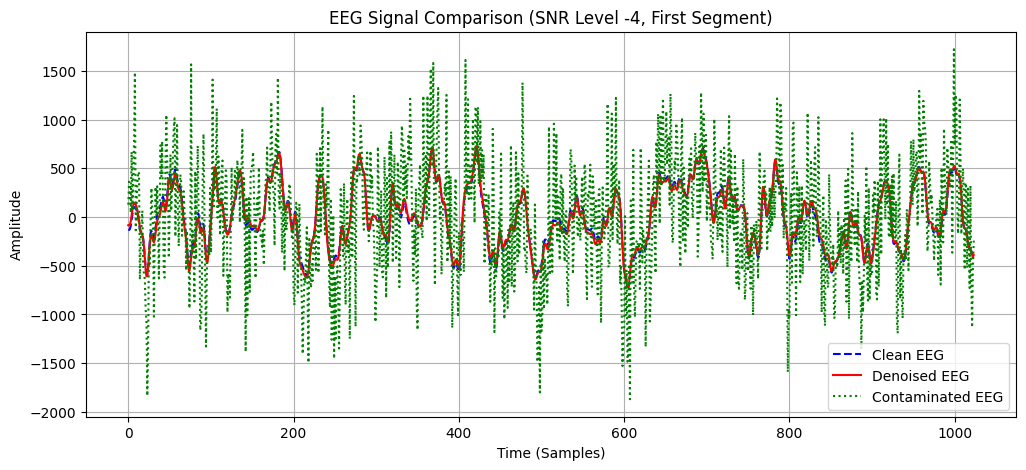

In [30]:
import numpy as np
import matplotlib.pyplot as plt

# Ensure required variables are loaded
try:
    print(f"✅ SNR Labels Shape: {snr_labels_test.shape}, Clean EEG Shape: {clean_eeg.shape}, Denoised EEG Shape: {denoised_eeg.shape}")
except NameError:
    print("❌ Variables are not defined. Re-run the data preparation and evaluation cells.")

# ✅ Convert SNR labels to integers safely
try:
    snr_labels_test_int = np.array([int(str(snr).replace("SNR_", "")) for snr in snr_labels_test])
    print(f"✅ Converted SNR Labels: {snr_labels_test_int[:10]} ...")  # Show first 10 for debugging
except Exception as e:
    print(f"❌ Error converting SNR labels: {e}")

# Set SNR level to check
snr_level = -4  

# ✅ Extract indices of test samples for the selected SNR level
snr_indices = np.where(snr_labels_test_int == snr_level)[0]

# ✅ Handle missing SNR level
if len(snr_indices) == 0:
    print(f"❌ No test samples found for SNR Level {snr_level}.")
else:
    print(f"\n📊 Found {len(snr_indices)} test samples for SNR Level {snr_level}")
    print(f"✅ SNR Level {snr_level} indices in test set: {snr_indices.tolist()}")

    # ✅ Select the first segment
    first_segment_idx = snr_indices[0]

    # ✅ Extract EEG segments
    clean_segment = clean_eeg[first_segment_idx]
    denoised_segment = denoised_eeg[first_segment_idx]

    # ✅ Reconstruct Contaminated EEG by summing all frequency bands
    contaminated_bands = [test_data[band][1] for band in bands]
    contaminated_eeg = np.sum(contaminated_bands, axis=0)
    contaminated_segment = contaminated_eeg[first_segment_idx]

    # ✅ Plot EEG signals
    plt.figure(figsize=(12, 5))
    plt.plot(clean_segment, label="Clean EEG", linestyle="dashed", color="blue", linewidth=1.5)
    plt.plot(denoised_segment, label="Denoised EEG", linestyle="solid", color="red", linewidth=1.5)
    plt.plot(contaminated_segment, label="Contaminated EEG", linestyle="dotted", color="green", linewidth=1.5)
    
    plt.title(f"EEG Signal Comparison (SNR Level {snr_level}, First Segment)")
    plt.xlabel("Time (Samples)")
    plt.ylabel("Amplitude")
    plt.legend()
    plt.grid(True)
    plt.show()



📊 Found 903 test samples for SNR Level -5
✅ SNR Level -5 indices in test set: [10, 17, 22, 44, 54, 56, 83, 84, 93, 101, 107, 116, 117, 126, 141, 146, 153, 157, 162, 176, 196, 198, 209, 211, 228, 233, 254, 262, 272, 296, 302, 306, 319, 322, 327, 333, 341, 345, 349, 364, 374, 403, 410, 440, 448, 456, 457, 467, 469, 474, 482, 484, 494, 499, 525, 548, 556, 574, 580, 581, 587, 590, 614, 615, 616, 631, 642, 667, 675, 682, 684, 685, 741, 756, 759, 765, 767, 772, 777, 794, 798, 804, 807, 808, 835, 836, 853, 856, 860, 865, 876, 893, 894, 895, 905, 917, 932, 942, 954, 956, 958, 983, 986, 991, 1000, 1004, 1009, 1019, 1025, 1034, 1036, 1056, 1057, 1075, 1077, 1079, 1125, 1128, 1131, 1141, 1142, 1148, 1157, 1159, 1163, 1172, 1190, 1196, 1200, 1205, 1211, 1212, 1236, 1237, 1254, 1258, 1265, 1269, 1288, 1298, 1305, 1307, 1309, 1317, 1347, 1355, 1359, 1364, 1367, 1376, 1392, 1393, 1398, 1402, 1419, 1421, 1422, 1426, 1449, 1470, 1493, 1499, 1514, 1519, 1521, 1524, 1528, 1549, 1567, 1568, 1578, 1584, 1

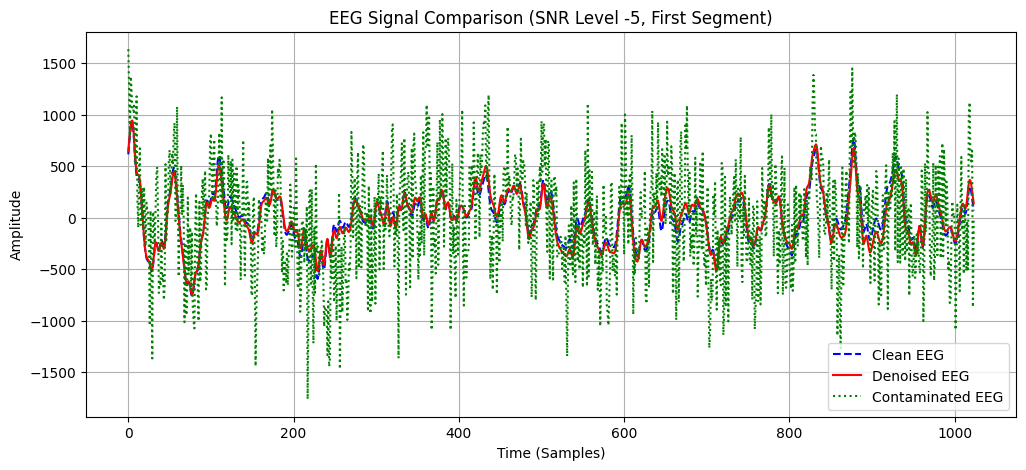

In [31]:
snr_level = -5  

# ✅ Extract indices of test samples for the selected SNR level
snr_indices = np.where(snr_labels_test_int == snr_level)[0]

# ✅ Handle missing SNR level
if len(snr_indices) == 0:
    print(f"❌ No test samples found for SNR Level {snr_level}.")
else:
    print(f"\n📊 Found {len(snr_indices)} test samples for SNR Level {snr_level}")
    print(f"✅ SNR Level {snr_level} indices in test set: {snr_indices.tolist()}")

    # ✅ Select the first segment
    first_segment_idx = snr_indices[0]

    # ✅ Extract EEG segments
    clean_segment = clean_eeg[first_segment_idx]
    denoised_segment = denoised_eeg[first_segment_idx]

    # ✅ Reconstruct Contaminated EEG by summing all frequency bands
    contaminated_bands = [test_data[band][1] for band in bands]
    contaminated_eeg = np.sum(contaminated_bands, axis=0)
    contaminated_segment = contaminated_eeg[first_segment_idx]

    # ✅ Plot EEG signals
    plt.figure(figsize=(12, 5))
    plt.plot(clean_segment, label="Clean EEG", linestyle="dashed", color="blue", linewidth=1.5)
    plt.plot(denoised_segment, label="Denoised EEG", linestyle="solid", color="red", linewidth=1.5)
    plt.plot(contaminated_segment, label="Contaminated EEG", linestyle="dotted", color="green", linewidth=1.5)
    
    plt.title(f"EEG Signal Comparison (SNR Level {snr_level}, First Segment)")
    plt.xlabel("Time (Samples)")
    plt.ylabel("Amplitude")
    plt.legend()
    plt.grid(True)
    plt.show()

In [33]:
# ✅ Get denoised EEG plotting points
x_points = list(range(len(denoised_segment)))      # X-axis: time/sample index
y_points = denoised_segment.tolist()               # Y-axis: denoised EEG values

# ✅ Print the plotting points
print("Denoised EEG Plotting Points:")
for x, y in zip(x_points, y_points):
    print(f"({x}, {y})")

Denoised EEG Plotting Points:
(0, 645.7418212890625)
(1, 742.0208740234375)
(2, 821.057373046875)
(3, 904.4400024414062)
(4, 941.2546997070312)
(5, 943.82177734375)
(6, 876.1100463867188)
(7, 769.0272216796875)
(8, 634.1043090820312)
(9, 521.0337524414062)
(10, 445.5328063964844)
(11, 418.0033874511719)
(12, 416.61920166015625)
(13, 407.3260803222656)
(14, 366.0279235839844)
(15, 283.8669128417969)
(16, 169.65106201171875)
(17, 43.347900390625)
(18, -79.76116943359375)
(19, -187.64198303222656)
(20, -276.47027587890625)
(21, -340.32464599609375)
(22, -379.7997131347656)
(23, -398.275390625)
(24, -407.652587890625)
(25, -422.9322814941406)
(26, -450.3351135253906)
(27, -485.99822998046875)
(28, -509.4646911621094)
(29, -498.7210998535156)
(30, -445.4691162109375)
(31, -362.6388244628906)
(32, -283.76422119140625)
(33, -239.29806518554688)
(34, -244.7386016845703)
(35, -280.98162841796875)
(36, -316.3355712890625)
(37, -323.93267822265625)
(38, -299.21429443359375)
(39, -261.63427734375)

In [36]:
x_points = list(range(len(clean_segment)))      # X-axis: time/sample index
y_points = clean_segment.tolist()               # Y-axis: denoised EEG values

# ✅ Print the plotting points
print("Clean EEG Plotting Points:")
for x, y in zip(x_points, y_points):
    print(f"({x}, {y})")

Clean EEG Plotting Points:
(0, 615.6761474609375)
(1, 717.7438354492188)
(2, 799.6842041015625)
(3, 882.4032592773438)
(4, 917.0758666992188)
(5, 917.9972534179688)
(6, 849.111083984375)
(7, 739.9368286132812)
(8, 603.3199462890625)
(9, 486.20025634765625)
(10, 410.0263977050781)
(11, 382.37664794921875)
(12, 381.94927978515625)
(13, 377.5799865722656)
(14, 341.54278564453125)
(15, 265.44488525390625)
(16, 156.9673614501953)
(17, 34.80204772949219)
(18, -85.44940185546875)
(19, -192.49905395507812)
(20, -281.7742614746094)
(21, -348.4753112792969)
(22, -391.2451171875)
(23, -411.92047119140625)
(24, -421.8576354980469)
(25, -434.8408203125)
(26, -461.4857482910156)
(27, -496.407470703125)
(28, -521.3375854492188)
(29, -512.2488403320312)
(30, -459.66241455078125)
(31, -375.5575866699219)
(32, -292.9281005859375)
(33, -244.00668334960938)
(34, -243.57571411132812)
(35, -276.514404296875)
(36, -311.21038818359375)
(37, -317.8133544921875)
(38, -291.10333251953125)
(39, -249.5558166503906

In [37]:
x_points = list(range(len(contaminated_segment)))      # X-axis: time/sample index
y_points = contaminated_segment.tolist()               # Y-axis: denoised EEG values

# ✅ Print the plotting points
print("Contaminated EEG Plotting Points:")
for x, y in zip(x_points, y_points):
    print(f"({x}, {y})")

Contaminated EEG Plotting Points:
(0, 1636.816070361743)
(1, 1255.2850481253274)
(2, 763.5658248409071)
(3, 1371.2704610095227)
(4, 1214.858189818279)
(5, 1036.1220509837347)
(6, 1032.3328417712632)
(7, 1087.9639431055539)
(8, 517.2689864260323)
(9, 528.5416792348122)
(10, 1178.8727902384012)
(11, 179.68500132485042)
(12, -96.96225110016258)
(13, 483.36617396307446)
(14, 674.2843680768159)
(15, -70.24361225892778)
(16, 88.72330748195434)
(17, 291.41012246909435)
(18, -104.79849199283755)
(19, 298.5690425826324)
(20, 71.04169568546118)
(21, -272.8132342914719)
(22, 145.82876770952512)
(23, 70.95407908384632)
(24, 66.29191860102065)
(25, -339.7998410699419)
(26, -1048.9778032871934)
(27, 67.90611508902703)
(28, -592.8372754847709)
(29, -1367.2753619160726)
(30, 57.92741236785503)
(31, 1.1991046516739345)
(32, -247.68671603577772)
(33, 105.08488878587039)
(34, 418.05548270448907)
(35, 493.7155648352034)
(36, -10.114869247719938)
(37, -730.5315126641855)
(38, -598.9569203743682)
(39, -661.

: 